# CAT Gratings to compare with MCs

In [1]:
import os
import numpy as np
import MotionClouds as mc
import datetime
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import imageio
import warnings
from psychopy import visual, core, event
import MotionClouds as MC
import itertools

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X//downscale, mc.N_Y//downscale, mc.N_frame//downscale)

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H:%M:%S")   

#original path during first cat expriments was MC_PSYCHOPY
mc.figpath = os.path.join('sequences/CATMC_gratings_%s'% strtime)
if not(os.path.isdir(mc.figpath)): os.mkdir(mc.figpath)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


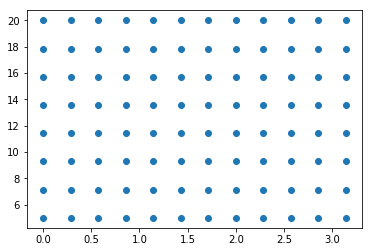

In [2]:
# Orientations
N_thetas = 12
thetas = np.linspace(0,np.pi, N_thetas) # we offset by pi/2 to prevent problems with matplotlib's displays and psychopy

# Noise
B_thetas = np.linspace(np.pi/2, np.pi/32, 8)/2.5
B_thetas = np.linspace(20, 5, 8)
# Presentation of each pattern
stim_duration = .02 #s

# Repetition of each block
repetition = 5

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))

plt.scatter(*zip(*sequence))

In [3]:
sorted_by_btheta = sorted(sequence, key=lambda tup: tup[1], reverse = True)
sorted_by_btheta
sequence = sorted_by_btheta

In [4]:
print('This protocolsetup lasts for approx. [%s] minutes (not counting blanks and inter-block screens)' % (N_thetas*len(B_thetas)*stim_duration*repetition/60))
print('Each of the [%s] block lasts for [%s]s' % (repetition, stim_duration*len(sequence)))
print('using [%s] thetas and [%s] b_thetas' % (N_thetas, len(B_thetas)))
print('and presenting each pattern for [%s]s' % stim_duration)

This protocolsetup lasts for approx. [0.16] minutes (not counting blanks and inter-block screens)
Each of the [5] block lasts for [1.92]s
using [12] thetas and [8] b_thetas
and presenting each pattern for [0.02]s


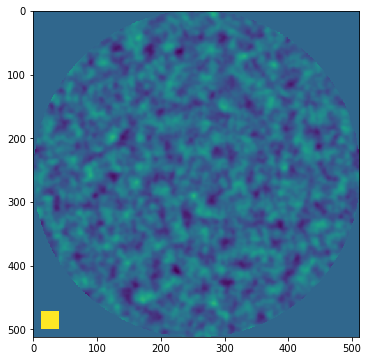

In [5]:
import imageio.core.util

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warn = silence_imageio_warning

def get_keypress():
    keys = event.getKeys()
    if keys:
        return keys[0]
    else:
        return None

def generate_cloud(theta, b_theta, itr,
                   N_X, N_Y, seed, contrast=1.,
                  transition = False, save = True):
    
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
    disk = mc.frequency_radius(fx, fy, ft) < .5

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=B_sf,
                             theta=theta, B_theta=b_theta)

    im_ = np.zeros((N_X, N_Y,1))
    im_ += mc.rectif(mc.random_cloud(mc_i, seed=seed),
                     contrast=contrast)
    im_ *= disk  # masking outside the disk
    im_ += -.5
    im_ += .5*(1-disk)  # gray outside the disk

    if transition : im_[472:500, 12:40] = 1
    else : im_[472:500, 12:40] = -.25

    # data appending
    if save :
        with open(mc.figpath+'/sequence.csv', "a+") as writer_file:
            data_writer = csv.writer(
                writer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow([itr, theta, b_theta, sf_0, B_sf, N_X, N_Y])
            
        imageio.imwrite(mc.figpath+'/%s.png' % itr, im_[:,:,0])

    return im_

width = 29.7*256/1050
N_X, N_Y = 512, 512
sf_0 = 4*width/N_X/2
B_sf = sf_0
im = generate_cloud(sequence[0][0], sequence[0][1], 1, N_X, N_Y, 42, transition = True, save = False)

plt.figure(figsize = (12,6))
plt.imshow(im[:,:,0])

In [6]:
from psychopy import visual, core, event

win = visual.Window(fullscr=True, color=[-1,-1,-1], winType='pygame', monitor='testMonitor', units='height')
mouse = event.Mouse(visible=False)

MC_temp = generate_cloud(theta = np.pi/2, b_theta=np.pi/2, contrast = 1, 
                        N_X = N_X, N_Y = N_Y, seed = 42, transition = False, itr = 0, save = False)

bitmap3 = visual.ImageStim(win, MC_temp, size=1, units='height')
bitmap3.autolog = False
bitmap3.setImage(np.full((512,512), -1))

for stimulations in range(len(sequence*repetition)):
    trial = stimulations%len(sequence)
    
    if stimulations == 0 :
        clock0 = core.Clock()
        print('Beginning new block, drawing blackscreen.')
        while clock0.getTime() < stim_duration*.3 :
            bitmap3.draw()
            win.flip()
            
    #INITIALISE SOME STIMULI
    grating1 = visual.GratingStim(win, mask="circle",
                                  color=[1.0, 1.0, 1.0],
                                  opacity=1.0,
                                  size=(1.08, 1.08),
                                  sf=(sequence[trial][1],0), 
                                  ori=(-sequence[trial][0]+np.pi/2)*180/np.pi)

    clock = core.Clock()
    print('Trial no.', trial)
    with open(mc.figpath+'/sequence.csv', "a+") as writer_file:
            data_writer = csv.writer(
                writer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow([(-sequence[trial][0]+np.pi/2)*180/np.pi,
                                  sequence[trial][1]])
            
    while clock.getTime() < stim_duration + .1:
        if clock.getTime() < stim_duration:  # fixation
            grating1.draw()
        win.flip()
        
        for keys in event.getKeys():
            if keys in ['escape','q']:
                win.close()
                core.quit()


Beginning new block, drawing blackscreen.
Trial no. 0
Trial no. 1
Trial no. 2
Trial no. 3
Trial no. 4
Trial no. 5
Trial no. 6
Trial no. 7
Trial no. 8
Trial no. 9
Trial no. 10
Trial no. 11
Trial no. 12
Trial no. 13
Trial no. 14
Trial no. 15
Trial no. 16
Trial no. 17
Trial no. 18
Trial no. 19
Trial no. 20
Trial no. 21
Trial no. 22
Trial no. 23
Trial no. 24
Trial no. 25
Trial no. 26
Trial no. 27
Trial no. 28
Trial no. 29
Trial no. 30
Trial no. 31
Trial no. 32
Trial no. 33
Trial no. 34
Trial no. 35
Trial no. 36
Trial no. 37
Trial no. 38
Trial no. 39
Trial no. 40
Trial no. 41
Trial no. 42
Trial no. 43
Trial no. 44
Trial no. 45
Trial no. 46
Trial no. 47
Trial no. 48
Trial no. 49
Trial no. 50
Trial no. 51
Trial no. 52
Trial no. 53
Trial no. 54
Trial no. 55
Trial no. 56
Trial no. 57
Trial no. 58
Trial no. 59
Trial no. 60
Trial no. 61
Trial no. 62
Trial no. 63
Trial no. 64
Trial no. 65
Trial no. 66
Trial no. 67
Trial no. 68
Trial no. 69
Trial no. 70
Trial no. 71
Trial no. 72
Trial no. 73
Trial 

In [7]:
win.close()

2.0170 	WARNING 	User requested fullscreen with size [800 600], but screen is actually [1920, 1080]. Using actual size
